# ML Project. Avito Demand Prediction Challenge

### Predict demand for an online classified ad
##### Executed by: Sodik Umurzakov



## 0. Introduction

The challenge is to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts.

#### Executive summary 
In this part of project, we are going to use Avito’s data from kaggle competition for predicting demand for an online classified ad using different characteristics like regions, description, price etc. We should highlight that there are also photos of the product attached, but we will not use it due to computations reasons.

When selling used goods online, a combination of tiny, nuanced details in a product description can make a big difference in drumming up interest. And, even with an optimized product listing, demand for a product may simply not exist–frustrating sellers who may have over-invested in marketing. Therefore, Avito is challenging us to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. With this information, Avito can inform sellers on how to best optimize their listing and provide some indication of how much interest they should realistically expect to receive.


## 1. Modules and functions

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn import preprocessing, model_selection, metrics
from subprocess import check_output
from io import StringIO 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import tarfile
from six.moves import urllib


color = sns.color_palette()
%matplotlib inline

import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Body

### 2.1 Data preparation

In the modelling process we want to use train data and other part of data from below listed files. The data has about 1 503 424 observations and more 17 columns that describe ads’ characteristics and related photos of ~140 GB which we will not use. So, there are a lot of features can be calculated using these 17 columns as we will include NLP as well for text descriptions and characteristics of ads and thorough EDA must be done to obtain consistent results. To avoid overfitting issues and fine tune of  perparameters, we will follow train / test split by 80% and 20% respectively and use k-fold cross validation which is applicable as we have cross sectional data. However, we should keep in mind that over train and test split must be done properly to account for representativity issues so we assess model on similar sample (shortly, we should compare apples with apples).

The description of the data files from the data page:

* train.csv - Train data.
* test.csv - Test data. Same schema as the train data, minus deal_probability.
* train_active.csv - Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data, minus deal_probability.
* test_active.csv - Supplemental data from ads that were displayed during the same period as test.csv. Same schema as the train data, minus deal_probability.
* periods_train.csv - Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.
* periods_test.csv - Supplemental data showing the dates when the ads from test_active.csv were activated and when they where displayed. Same schema as periods_train.csv, except that the item ids map to an ad in test_active.csv.
* train_jpg.zip - Images from the ads in train.csv.
* test_jpg.zip - Images from the ads in test.csv.
* sample_submission.csv - A sample submission in the correct format.

Let us start with the train file.

In [2]:
train_df = pd.read_csv("train.csv", parse_dates=["activation_date"])
print("Train file rows and columns are : ", train_df.shape)

Train file rows and columns are :  (1503424, 18)


Above we can see that the number of sample of the dataset which is equal to 1 503 424 and number of variables is 18. We parsed dates for activation date variable

In [3]:
train_df.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   Свердловская область      Екатеринбург   
1  2dac0150717d  39aeb48f0017      Самарская область            Самара   
2  ba83aefab5dc  91e2f88dd6e3     Ростовская область    Ростов-на-Дону   
3  02996f1dd2ea  bf5cccea572d              Татарстан  Набережные Челны   
4  7c90be56d2ab  ef50846afc0b  Волгоградская область         Волгоград   

  parent_category_name               category_name  \
0          Личные вещи  Товары для детей и игрушки   
1      Для дома и дачи           Мебель и интерьер   
2  Бытовая электроника               Аудио и видео   
3          Личные вещи  Товары для детей и игрушки   
4            Транспорт                  Автомобили   

                       param_1     param_2 param_3                  title  \
0    Постельные принадлежности         NaN     NaN  Кокоби(кокон для сна)   
1                       Другое         NaN     NaN      Стойка для Одежды   
2  Видео, DVD и Blu-ray плееры         NaN     NaN         Philips bluray   
3         Автомобильные кресла         NaN     NaN             Автокресло   
4                   С пробегом  ВАЗ (LADA)    2110         ВАЗ 2110, 2003   

                                         description    price  \
0  Кокон для сна малыша,пользовались меньше месяц...    400.0   
1          Стойка для одежды, под вешалки. С бутика.   3000.0   
2  В хорошем состоянии, домашний кинотеатр с blu ...   4000.0   
3                             Продам кресло от0-25кг   2200.0   
4                           Все вопросы по телефону.  40000.0   

   item_seq_number activation_date user_type  \
0                2      2017-03-28   Private   
1               19      2017-03-26   Private   
2                9      2017-03-20   Private   
3              286      2017-03-25   Company   
4                3      2017-03-16   Private   

                                               image  image_top_1  \
0  d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...       1008.0   
1  79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...        692.0   
2  b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...       3032.0   
3  e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...        796.0   
4  54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...       2264.0   

   deal_probability  
0           0.12789  
1           0.00000  
2           0.43177  
3           0.80323  
4           0.20797

The train dataset description is as follows:

* item_id - Ad id.
* user_id - User id.
* region - Ad region.
* city - Ad city.
* parent_category_name - Top level ad category as classified by Avito's ad model.
* category_name - Fine grain ad category as classified by Avito's ad model.
* param_1 - Optional parameter from Avito's ad model.
* param_2 - Optional parameter from Avito's ad model.
* param_3 - Optional parameter from Avito's ad model.
* title - Ad title.
* description - Ad description.
* price - Ad price.
* item_seq_number - Ad sequential number for user.
* activation_date- Date ad was placed.
* user_type - User type.
* image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
* image_top_1 - Avito's classification code for the image.
* deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

So deal probability is our target variable and  is a float value between 0 and 1 as per the data page. Let us have a look at it. 

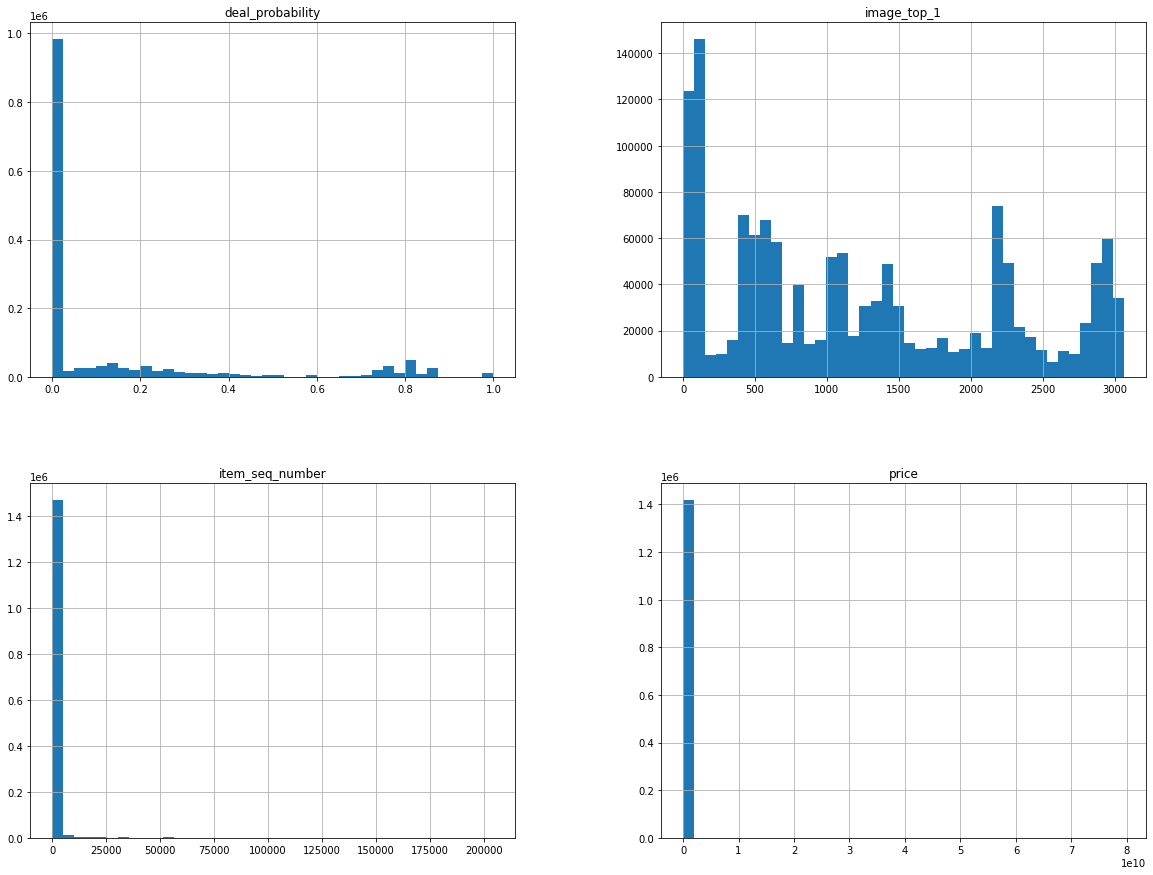

In [4]:

%matplotlib inline
import matplotlib.pyplot as plt
train_df.hist(bins=40, figsize=(20,15));
plt.show();

Above plot depicts the countable variables with thier distribution. As our target is deal probability and it has most distributed around zero. The target variable is decomposed by regions and category of products that are sold mostly and shows that most of goods are not sold as well as its around zero. Other non-target variables are also mostly around zero.
Many suck kind of histograms are tail heavy and they extend to the right of
the median than to the left. This reason would call some problems for ML algorithms to fix best patterns.

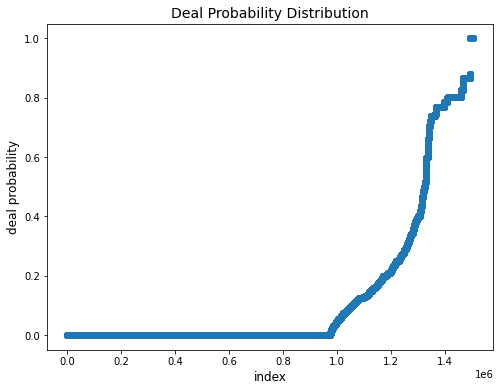

In [5]:
plt.figure(figsize=(8,6));
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values));
plt.xlabel('index', fontsize=12);
plt.ylabel('deal probability', fontsize=12);
plt.title("Deal Probability Distribution", fontsize=14);
plt.show();

From above plot we can say that almost 100 th. Ads has 0 probaility which means that it did not sell anything and few ads have a probability of 1. Rest of the deal probabilities have values in between 0 and 1.

In [6]:
train_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   item_id               1503424 non-null  object        
 1   user_id               1503424 non-null  object        
 2   region                1503424 non-null  object        
 3   city                  1503424 non-null  object        
 4   parent_category_name  1503424 non-null  object        
 5   category_name         1503424 non-null  object        
 6   param_1               1441848 non-null  object        
 7   param_2               848882 non-null   object        
 8   param_3               640859 non-null   object        
 9   title                 1503424 non-null  object        
 10  description           1387148 non-null  object        
 11  price                 1418062 non-null  float64       
 12  item_seq_number       1503424 non-null  in

In [7]:
train_df["deal_probability"].value_counts()

0.00000    974618
0.80323     46683
0.76786     26489
0.86521     23275
0.73760     13928
            ...  
0.18077         1
0.25703         1
0.21164         1
0.15112         1
0.13236         1
Name: deal_probability, Length: 18407, dtype: int64

In [8]:
train_df.describe().style.format("{:.2f}")

## 3. Creating test set

We have divided our data into two parts: train and test by function train test split. Train – 80% and test – 20% of data. Below we can see the characteristics of the target variable one more time and for another new variable from test set – deal hat. The deal hat variable has been created by pandas.cut() function wuth bins and 6 lables.

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(train_df, test_size=0.2, random_state=42)

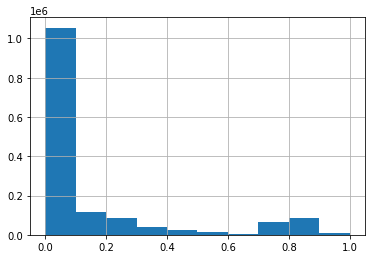

In [10]:
hist = train_df["deal_probability"].hist();

As we can see above that target variable is mostly distributed around zero. The target variable is decomposed by regions and category of products that are sold mostly and shows that most of goods are not sold as well as its around zero. For the new variable – deal hat we see that it also distributed around category 1 and 2.

We have catched the issue and now it works good

In [11]:
train_set.user_id.shape
test_set.user_id.shape

(1202739,)

(300685,)

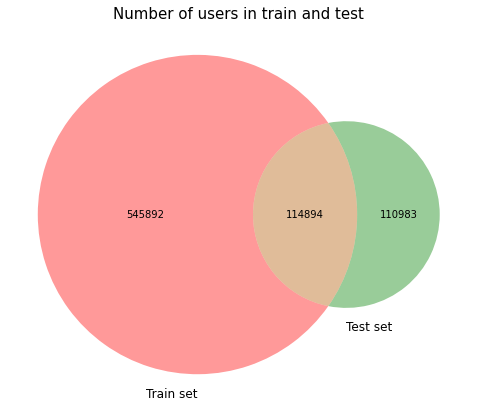

In [12]:
from matplotlib_venn import venn2 

#Plot the number of users into train and test

plt.figure(figsize=(10,7))
venn2([set(train_set.user_id.unique()), set(test_set.user_id.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Number of users in train and test", fontsize=15)
plt.show();

In [13]:
train_set.title.shape
test_set.title.shape

(1202739,)

(300685,)

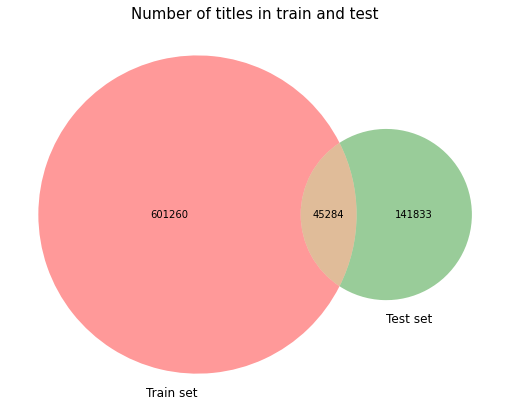

In [14]:
#Plot the number of titles into train and test
plt.figure(figsize=(10,7))
venn2([set(train_set.title.unique()), set(test_set.title.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Number of titles in train and test", fontsize=15)
plt.show();

The number of users in train set – 1 202 739 and in test set – 300 685, but interception of these two sets – 114 894. Uniqueness for train – 545 892 and for test set – 110 983.
The number of titles in train set - 1 202 739 and in test set – 300 685, but interception of these two sets – 45 284. Uniqueness for train – 601 260 and for test set – 141 833.
So, we conclude that with these decomposed sets will deal further in ML algorithmic modelling. Now, let’s try to focus on the correlation of the target variable with others.


In [15]:
train_df.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   Свердловская область      Екатеринбург   
1  2dac0150717d  39aeb48f0017      Самарская область            Самара   
2  ba83aefab5dc  91e2f88dd6e3     Ростовская область    Ростов-на-Дону   
3  02996f1dd2ea  bf5cccea572d              Татарстан  Набережные Челны   
4  7c90be56d2ab  ef50846afc0b  Волгоградская область         Волгоград   

  parent_category_name               category_name  \
0          Личные вещи  Товары для детей и игрушки   
1      Для дома и дачи           Мебель и интерьер   
2  Бытовая электроника               Аудио и видео   
3          Личные вещи  Товары для детей и игрушки   
4            Транспорт                  Автомобили   

                       param_1     param_2 param_3                  title  \
0    Постельные принадлежности         NaN     NaN  Кокоби(кокон для сна)   
1                       Другое         NaN     NaN      Стойка для Одежды   
2  Видео, DVD и Blu-ray плееры         NaN     NaN         Philips bluray   
3         Автомобильные кресла         NaN     NaN             Автокресло   
4                   С пробегом  ВАЗ (LADA)    2110         ВАЗ 2110, 2003   

                                         description    price  \
0  Кокон для сна малыша,пользовались меньше месяц...    400.0   
1          Стойка для одежды, под вешалки. С бутика.   3000.0   
2  В хорошем состоянии, домашний кинотеатр с blu ...   4000.0   
3                             Продам кресло от0-25кг   2200.0   
4                           Все вопросы по телефону.  40000.0   

   item_seq_number activation_date user_type  \
0                2      2017-03-28   Private   
1               19      2017-03-26   Private   
2                9      2017-03-20   Private   
3              286      2017-03-25   Company   
4                3      2017-03-16   Private   

                                               image  image_top_1  \
0  d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...       1008.0   
1  79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...        692.0   
2  b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...       3032.0   
3  e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...        796.0   
4  54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...       2264.0   

   deal_probability  
0           0.12789  
1           0.00000  
2           0.43177  
3           0.80323  
4           0.20797

In [16]:
avito_df = train_df.copy()

In [17]:
avito_df.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   Свердловская область      Екатеринбург   
1  2dac0150717d  39aeb48f0017      Самарская область            Самара   
2  ba83aefab5dc  91e2f88dd6e3     Ростовская область    Ростов-на-Дону   
3  02996f1dd2ea  bf5cccea572d              Татарстан  Набережные Челны   
4  7c90be56d2ab  ef50846afc0b  Волгоградская область         Волгоград   

  parent_category_name               category_name  \
0          Личные вещи  Товары для детей и игрушки   
1      Для дома и дачи           Мебель и интерьер   
2  Бытовая электроника               Аудио и видео   
3          Личные вещи  Товары для детей и игрушки   
4            Транспорт                  Автомобили   

                       param_1     param_2 param_3                  title  \
0    Постельные принадлежности         NaN     NaN  Кокоби(кокон для сна)   
1                       Другое         NaN     NaN      Стойка для Одежды   
2  Видео, DVD и Blu-ray плееры         NaN     NaN         Philips bluray   
3         Автомобильные кресла         NaN     NaN             Автокресло   
4                   С пробегом  ВАЗ (LADA)    2110         ВАЗ 2110, 2003   

                                         description    price  \
0  Кокон для сна малыша,пользовались меньше месяц...    400.0   
1          Стойка для одежды, под вешалки. С бутика.   3000.0   
2  В хорошем состоянии, домашний кинотеатр с blu ...   4000.0   
3                             Продам кресло от0-25кг   2200.0   
4                           Все вопросы по телефону.  40000.0   

   item_seq_number activation_date user_type  \
0                2      2017-03-28   Private   
1               19      2017-03-26   Private   
2                9      2017-03-20   Private   
3              286      2017-03-25   Company   
4                3      2017-03-16   Private   

                                               image  image_top_1  \
0  d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...       1008.0   
1  79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...        692.0   
2  b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...       3032.0   
3  e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...        796.0   
4  54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...       2264.0   

   deal_probability  
0           0.12789  
1           0.00000  
2           0.43177  
3           0.80323  
4           0.20797

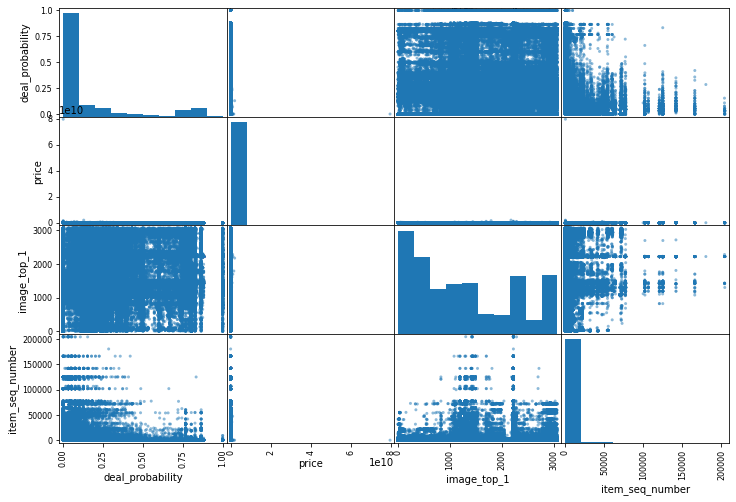

In [18]:
from pandas.plotting import scatter_matrix

attributes = ["deal_probability", "price", "image_top_1",
              "item_seq_number"]
scatter_matrix(avito_df[attributes], figsize=(12, 8));

Above we have created test set for our ML algorithms for further steps. In in the last histagram we have decomposed the ratio of the target varialbe for 6 categorical part

In [19]:
corr_matr = avito_df.corr()
print(corr_matr)

                     price  item_seq_number  image_top_1  deal_probability
price             1.000000         0.004246     0.034404         -0.001097
item_seq_number   0.004246         1.000000     0.091472         -0.035744
image_top_1       0.034404         0.091472     1.000000          0.189979
deal_probability -0.001097        -0.035744     0.189979          1.000000


In [20]:
corr_matr["deal_probability"].sort_values(ascending=False)

deal_probability    1.000000
image_top_1         0.189979
price              -0.001097
item_seq_number    -0.035744
Name: deal_probability, dtype: float64

There are some correlations among these variables. Usually, the correlation coefficient which is ranged from –1 to 1. In case when it is close to 1, it means that there is a good positive correlation. In case when the coefficient is around –1, it means that there is a negative correlation. As we see negative correlation between our target variable with price and Ad sequential number for user. Because these two variables can’t be useful for deal probability. Finally, coefficients close to zero means that there is no linear correlation. 

For now, we want to skip with test set for EDA analysis as we know that test set helps us in modelling part to predict the demand for classified ads. Therefore, we would like to focus on train set for EDA analysis for this part.



### 4. Data Visualization
#### 4.1. Region wise distribution of Ads:

In [21]:
# Have to convert from Russian into English

temp_data = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, region_df, how="left", on="region")

In [22]:
temp_series = train_df['region_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Region distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

The main purpose of region distribution is about how to make a decision in what region actively use Ads for sales. Further, we have to work on with those regions to find a pattern how to predict demand for Ads and sales among avito users. The regions have percentage of ads between 1.71% to 9.41%. The top regions are:
1.	Krasnodar region - 9.41%
2.	Sverdlovsk region - 6.28%
3.	Rostov region - 5.99%
4.	Tatarstan - 5.41%

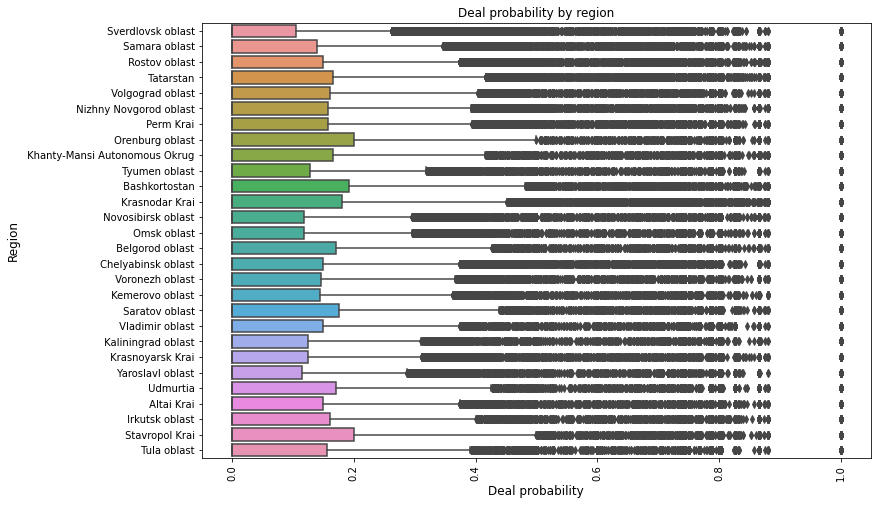

In [23]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region_en", x="deal_probability", data=train_df)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show();

The plot shows the probability of deal conducting among various regions. It means in what regions ads effectively generate used goods for sales. Below the deal probability by region and leading regions are:
1.	Sverdlovs oblast
2.	Samara oblast
3.	Rostov oblast
4.	Tatarstan
5.	Volgograd oblast


Sverdlovs and Samara oblasts are the highest one, we have to make sure the reason of this. In my point of view, it depends on wage level of the regions and they have not enough high wages and population density in Ural comparing to other regions. Most part of population prefers to buy used goods because of wages.  Further, we try to analyze the situation in case of top cities distributed by ads.


#### 4.2. City wise distribution of Ads:

Now let us have a look at the top 20 cities present in the dataset.

In [24]:
temp_data = StringIO("""
city,city_en
Краснодар,Krasnodar
Екатеринбург,Ekaterinburg
Новосибирск,Novosibirsk
Ростов-на-Дону, Rostov
Нижний-Новгород, Nizhniy Novgorog
Челябинск, Chelyabinsk
Пермь, Perm
Казань, Kazan
Самара, Samara
Омск, Omsk
Уфа, Ufa
Красноярск, Krasnoyarsk
Воронеж, Voronezh
Волгоград, Volgograd
Саратов, Saratov
Тюмень, Tyumen
Калининград, Kaliningrad
Барнаул, Barnaul
Ярославль, Yaroslavl
Иркутск, Irkutsk
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="city", how="left")

In [25]:
cnt_srs = train_df['city_en'].value_counts().head(20)
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='City distribution of Ads',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="CityAds")

In this plot we see the top cities where the ads are depicted.
- Krasnodar
- Ekaterinburg
- Novosibirsk
- Rostov

If we compare cities with regions, then we can make an option that two factors effect on Ads motivation: 1. Population density; 2. Wage level. As we see from plot approximately 65k ads come from that category of cities. Regarding the current situation of COVID-19 when Further, we can create a pattern for other non-top cities to create a demand.


#### 4.3. Parent Category Name:

Now let us look at the distribution of parent cateory names.

In [26]:
temp_data = StringIO("""
parent_category_name,parent_category_name_en
Личные вещи,Personal belongings
Для дома и дачи,For the home and garden
Бытовая электроника,Consumer electronics
Недвижимость,Real estate
Хобби и отдых,Hobbies & leisure
Транспорт,Transport
Услуги,Services
Животные,Animals
Для бизнеса,For business
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="parent_category_name", how="left")

In [27]:
temp_series = train_df['parent_category_name_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Parent Category distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="parentcategory");

We see the situation of category distribution, 46.4% of the ads are for Personal belongings, 11.9% are for home and garden, 11.5% for consumer electronics, 10.2% for real estate. As usual in Avito platform where used goods are sold has high amount of share in personal belongings. And, we have to work on this category and to predict demand for Ads, therefore, it follows to make an accent in ML pipeline for demand prediction.

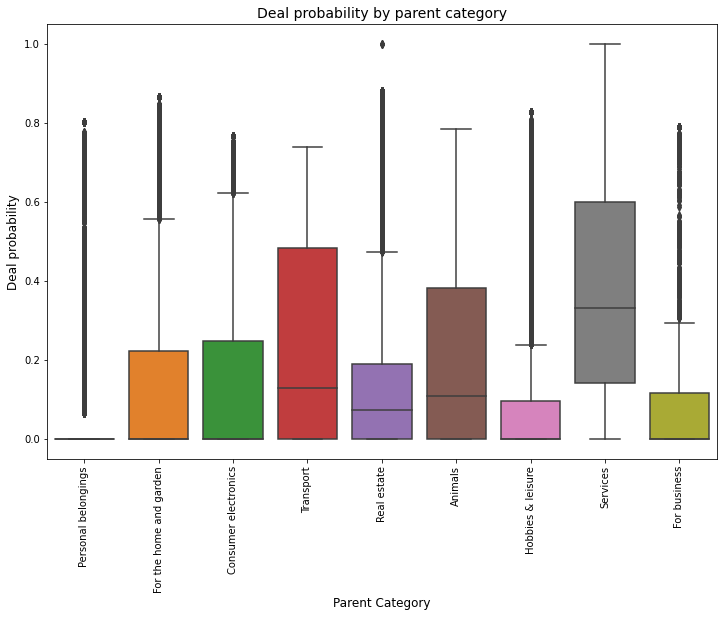

In [28]:
plt.figure(figsize=(12,8))
sns.boxplot(x="parent_category_name_en", y="deal_probability", data=train_df)
plt.ylabel('Deal probability', fontsize=12)
plt.xlabel('Parent Category', fontsize=12)
plt.title("Deal probability by parent category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show();

In this box we see that Services, Transport and Animals categories seem to have slightly higher deal probability compared to others. The key reason is non-durable products as services promotion are less expensive, therefore, the deal probability is higher to compare with other categories. As we see from above plot avito ads platform is not effectively suits for business development and hobbies and leisure, first, these categories are not so popular, second, for suck kinds of categories need to promote with high qualified persons from official webs or from Universities. So, our main goal should be filtering interested categories and focus on them for prediction.  

#### 4.4. Category of Ads:

Now let us look at the category of ads.

In [29]:
temp_data = StringIO("""
category_name,category_name_en
"Одежда, обувь, аксессуары","Clothing, shoes, accessories"
Детская одежда и обувь,Children's clothing and shoes
Товары для детей и игрушки,Children's products and toys
Квартиры,Apartments
Телефоны,Phones
Мебель и интерьер,Furniture and interior
Предложение услуг,Offer services
Автомобили,Cars
Ремонт и строительство,Repair and construction
Бытовая техника,Appliances
Товары для компьютера,Products for computer
"Дома, дачи, коттеджи","Houses, villas, cottages"
Красота и здоровье,Health and beauty
Аудио и видео,Audio and video
Спорт и отдых,Sports and recreation
Коллекционирование,Collecting
Оборудование для бизнеса,Equipment for business
Земельные участки,Land
Часы и украшения,Watches and jewelry
Книги и журналы,Books and magazines
Собаки,Dogs
"Игры, приставки и программы","Games, consoles and software"
Другие животные,Other animals
Велосипеды,Bikes
Ноутбуки,Laptops
Кошки,Cats
Грузовики и спецтехника,Trucks and buses
Посуда и товары для кухни,Tableware and goods for kitchen
Растения,Plants
Планшеты и электронные книги,Tablets and e-books
Товары для животных,Pet products
Комнаты,Room
Фототехника,Photo
Коммерческая недвижимость,Commercial property
Гаражи и машиноместа,Garages and Parking spaces
Музыкальные инструменты,Musical instruments
Оргтехника и расходники,Office equipment and consumables
Птицы,Birds
Продукты питания,Food
Мотоциклы и мототехника,Motorcycles and bikes
Настольные компьютеры,Desktop computers
Аквариум,Aquarium
Охота и рыбалка,Hunting and fishing
Билеты и путешествия,Tickets and travel
Водный транспорт,Water transport
Готовый бизнес,Ready business
Недвижимость за рубежом,Property abroad
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="category_name", how="left")

In [30]:
cnt_srs = train_df['category_name_en'].value_counts()
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='Category Name of Ads - Count',
    height=900
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="category name");

There are the top 3 categories demonstrated:
1.	Clothes, shoes, accessories
2.	Children's clothing and footwear
3.	Goods for children and toys

From this picture we can say, approximately 60% of ads come from top 3 categories for adult and children, and it means that avito platform targeted on clothes, shoes, accessories.


#### 4.5.  User Type:

Now let us look at the user type. 

In [31]:
temp_series = train_df['user_type'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='User Type distribution',
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype");

Private users constitute 72% of the data followed by company and shop. But company share’s also huge and it is necessary to care about the quality of ads to increase this category. Because most users think about the security of the bought products. When the private is 71.6% out of 100% then it is more challengeable to predict the behaviour of the users and is not easy to analyse the ads content.

#### 4.6. Price:

This is the price shown in the Ad.

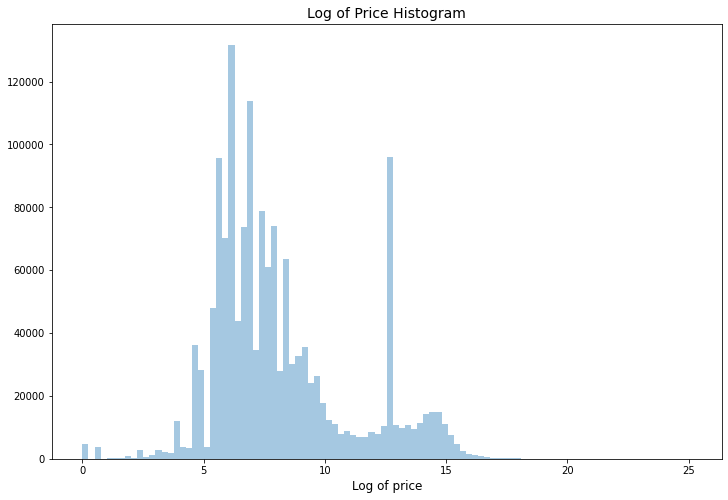

In [32]:
train_df["price_new"] = train_df["price"].values
train_df["price_new"].fillna(np.nanmean(train_df["price"].values), inplace=True)

plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_df["price_new"].values), bins=100, kde=False)
plt.xlabel('Log of price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show();

Here the log of price distribution is depicted it shows us the approximately 140k goods have log of price around 6-7. But we see that there are outliers in the dataset, and we have to drop them from our sample and try to get normally distributed log of price. 

We have around 110K common titles between train and test set. Now let us look at the number of words present in the title column.

In [33]:
train_df["title_nwords"] = train_df["title"].apply(lambda x: len(x.split()))

cnt_srs = train_df['title_nwords'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in title column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_nwords")           

As we see above the number of words in the combined title column where decomposed to 10 categories. And, in the second category of goods the number of words is ~ 370k. With this information, Avito can inform sellers on how to best optimize their listing and provide some indication of how much interest they should realistically expect to receive. Further, we have to care about how to optimize the volume of words for sellers and recommend optimal amount to concentrate on key information.

#### 4.7. Description:

Let us first check the number of words in the description column.

In [34]:
## Filling missing values ##
train_df["description"].fillna("NA", inplace=True)

train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(x.split()))

cnt_srs = train_df['desc_nwords'].value_counts().head(100)

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in Description column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="desc_nwords") 

Description column has a huge right tail till about 700 words. We have cut the same till top 100 for better visualization. But most of them left tail till approximately 135k goods that are generated for clothes, shoes, accessories etc. Further, we have to manipulate with the number of words for sellers to create online Ads.

In [35]:
train_df.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   Свердловская область      Екатеринбург   
1  2dac0150717d  39aeb48f0017      Самарская область            Самара   
2  ba83aefab5dc  91e2f88dd6e3     Ростовская область    Ростов-на-Дону   
3  02996f1dd2ea  bf5cccea572d              Татарстан  Набережные Челны   
4  7c90be56d2ab  ef50846afc0b  Волгоградская область         Волгоград   

  parent_category_name               category_name  \
0          Личные вещи  Товары для детей и игрушки   
1      Для дома и дачи           Мебель и интерьер   
2  Бытовая электроника               Аудио и видео   
3          Личные вещи  Товары для детей и игрушки   
4            Транспорт                  Автомобили   

                       param_1     param_2 param_3                  title  \
0    Постельные принадлежности         NaN     NaN  Кокоби(кокон для сна)   
1                       Другое         NaN     NaN      Стойка для Одежды   
2  Видео, DVD и Blu-ray плееры         NaN     NaN         Philips bluray   
3         Автомобильные кресла         NaN     NaN             Автокресло   
4                   С пробегом  ВАЗ (LADA)    2110         ВАЗ 2110, 2003   

                                         description    price  \
0  Кокон для сна малыша,пользовались меньше месяц...    400.0   
1          Стойка для одежды, под вешалки. С бутика.   3000.0   
2  В хорошем состоянии, домашний кинотеатр с blu ...   4000.0   
3                             Продам кресло от0-25кг   2200.0   
4                           Все вопросы по телефону.  40000.0   

   item_seq_number activation_date user_type  \
0                2      2017-03-28   Private   
1               19      2017-03-26   Private   
2                9      2017-03-20   Private   
3              286      2017-03-25   Company   
4                3      2017-03-16   Private   

                                               image  image_top_1  \
0  d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...       1008.0   
1  79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...        692.0   
2  b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...       3032.0   
3  e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...        796.0   
4  54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...       2264.0   

   deal_probability           region_en       city_en  \
0           0.12789   Sverdlovsk oblast  Ekaterinburg   
1           0.00000       Samara oblast        Samara   
2           0.43177       Rostov oblast        Rostov   
3           0.80323           Tatarstan           NaN   
4           0.20797    Volgograd oblast     Volgograd   

   parent_category_name_en              category_name_en  price_new  \
0      Personal belongings  Children's products and toys      400.0   
1  For the home and garden        Furniture and interior     3000.0   
2     Consumer electronics               Audio and video     4000.0   
3      Personal belongings  Children's products and toys     2200.0   
4                Transport                          Cars    40000.0   

   title_nwords  desc_nwords  
0             3            7  
1             3            7  
2             2           17  
3             1            3  
4             3            4

## 5. Feature generation for models 

In [38]:
# New variable on weekday #
train_df["activation_weekday"] = train_df["activation_date"].dt.weekday

# Label encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "region_en", "region_en", "city_en", "parent_category_name_en", "category_name_en", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    

cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image", "deal_probability"]
train_X1 = train_df.drop(cols_to_drop, axis=1);

region
city
parent_category_name
category_name
region_en
region_en
city_en
parent_category_name_en
category_name_en
user_type
param_1
param_2
param_3


In [40]:
X = train_X1
y = train_df["deal_probability"]

In [41]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
train_X.shape

(1202739, 19)

### 6. Modelling

In [43]:
pd.isnull(train_X).sum()

region                         0
city                           0
parent_category_name           0
category_name                  0
param_1                        0
param_2                        0
param_3                        0
price                      68593
item_seq_number                0
user_type                      0
image_top_1                90077
region_en                      0
city_en                        0
parent_category_name_en        0
category_name_en               0
price_new                      0
title_nwords                   0
desc_nwords                    0
activation_weekday             0
dtype: int64

In [44]:
train_X['price'] = train_X['price'].fillna(train_X['price'].median())

train_X['image_top_1'] = train_X['image_top_1'].fillna(train_X['image_top_1'].median())

In [45]:
pd.isnull(train_X).sum()

region                     0
city                       0
parent_category_name       0
category_name              0
param_1                    0
param_2                    0
param_3                    0
price                      0
item_seq_number            0
user_type                  0
image_top_1                0
region_en                  0
city_en                    0
parent_category_name_en    0
category_name_en           0
price_new                  0
title_nwords               0
desc_nwords                0
activation_weekday         0
dtype: int64

In [46]:
train_X.head()

region  city  parent_category_name  category_name  param_1  param_2  \
1501077       5   116                     0             18       32      107   
51680         1   656                     8             35      131      107   
26826         3  1096                     2             31       32      107   
867845       19  1627                     4              2      105      122   
137360        1   656                     2             34      108      204   

         param_3    price  item_seq_number  user_type  image_top_1  region_en  \
1501077     1162     50.0               18          1       2789.0          4   
51680       1162    500.0               30          1       2645.0          1   
26826       1162     80.0               25          1        406.0          2   
867845       203   1500.0              182          1         94.0         21   
137360      1162  18990.0              422          2       1852.0          1   

         city_en  parent_category_name_en  category_name_en  price_new  \
1501077        6                        1                14       50.0   
51680         12                        4                40      500.0   
26826         19                        3                34       80.0   
867845        19                        5                 9     1500.0   
137360        12                        3                 1    18990.0   

         title_nwords  desc_nwords  activation_weekday  
1501077             2            4                   1  
51680               7            8                   3  
26826               3           27                   3  
867845              4            8                   6  
137360              6          291                   3

In this section we are going to deal with the modelling process and try to follow the framework how to build a model.  We have decided to use advanced ML algorithm. This task is a regression problem as we have deal probability which is continuous variable between 0 and 1 where we are going to use state-of-the-art classical ML models such as XGBoost and Light GBM. Eventually, we will try to stack the models to see if there is an uplift in prediction power. Thus, optimization metric is MSE (mean squared error) that is default ones for such tasks and based on how we should punish deviations from true values use one of them. MSE metric punishes deviations more due to squared power. Now, let’s proceed the XGBoost model.

### XGBoost

In [77]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV



# init model
xgb_model = xgb.XGBRegressor(n_estimators = 550, seed = 42)
setattr(xgb_model, 'verbosity', 2)

# set params dict
xgb_params = {'learning_rate': [0.03, 0.15, 0.1],
              'max_depth': [3, 4, 5]}
# fit GS
xgb_GS = RandomizedSearchCV(estimator = xgb_model, param_distributions = xgb_params, scoring = 'neg_mean_squared_error')
xgb_GS.fit(X=train_X, y=train_y)

[01:58:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:58:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:58:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:58:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:58:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:58:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:58:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[01:59:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:59:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:59:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:59:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:59:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:59:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:59:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:00:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:00:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:00:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:00:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:00:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:00:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:00:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:01:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:01:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:01:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:01:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:01:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:01:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:01:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:02:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:02:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:02:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:02:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:02:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:02:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:02:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:04:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:04:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:04:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:04:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:04:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:04:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:04:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:05:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:05:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:05:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:05:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:05:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:05:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:05:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:06:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:06:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:06:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:07:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:07:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:07:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:07:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:07:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:07:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[02:07:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:07:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:07:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:08:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:08:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:08:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:08:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:08:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:08:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:09:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:09:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:09:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:09:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:09:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:09:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:09:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:09:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:10:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:10:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:10:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:10:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:10:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:10:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:10:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:11:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:11:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:11:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:11:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:11:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:11:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:11:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:12:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:12:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:12:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:12:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:12:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:12:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:12:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:13:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:13:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:13:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:13:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:13:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:13:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:13:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:14:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:14:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:14:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:14:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:14:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:14:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:14:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:15:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:15:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:15:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:15:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:15:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:15:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:15:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:16:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:16:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:16:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:16:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:16:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:16:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:16:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:17:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:17:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:17:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:17:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:17:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:17:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:17:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:18:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:18:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:18:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:18:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:18:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:18:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:18:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:19:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:19:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:19:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:19:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:19:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:19:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:19:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:20:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:20:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:20:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:20:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:20:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:20:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:20:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:21:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:21:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:21:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:21:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:21:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:21:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:21:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:22:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:22:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:22:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:22:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:22:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:22:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:22:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:22:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:23:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:23:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:24:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:24:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:24:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:24:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:24:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:24:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:24:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:25:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:25:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:25:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:25:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:25:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:25:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:25:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:26:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:26:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:26:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:26:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:26:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:26:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:26:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:27:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:27:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:27:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:27:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:27:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:27:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:27:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:28:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:28:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:28:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:28:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:28:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:28:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:28:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:29:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:29:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:29:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:29:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:29:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:29:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:29:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:30:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:30:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:30:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:30:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:30:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:30:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:30:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:31:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:31:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:31:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:31:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:31:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:31:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:31:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:32:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:32:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:32:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:32:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:32:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:32:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:32:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:33:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:33:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:33:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:33:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:33:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:33:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:33:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:34:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:34:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:34:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:34:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:34:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:34:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:34:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:35:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:35:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:35:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:35:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:35:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:35:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:35:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:36:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:36:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:36:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:36:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:36:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:36:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:36:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:36:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:36:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:36:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:37:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:37:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:37:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:37:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:38:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:38:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:38:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:38:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:38:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:38:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:38:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:39:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:39:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:39:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:39:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:39:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:39:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:39:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:40:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:40:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:40:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:40:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:40:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:40:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:40:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:41:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:41:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:41:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:41:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:41:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:41:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:41:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:42:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:42:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:42:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:42:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:42:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:42:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:42:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:43:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:43:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:43:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:43:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:43:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:43:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:43:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3

[02:44:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:44:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:44:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:44:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:44:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:44:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:44:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[02:45:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:45:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:45:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:45:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:45:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:45:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:45:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:46:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:46:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:46:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:46:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:46:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:46:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:46:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:47:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:47:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:47:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:47:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:47:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:47:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:47:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:49:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:49:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:49:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:49:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:49:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:49:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:49:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:50:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:50:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:50:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:50:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:50:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:50:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:50:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:51:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[02:51:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:51:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:51:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:51:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:51:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:51:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:52:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:52:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[02:52:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:52:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:52:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:52:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:52:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:54:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:54:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:54:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:54:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[02:54:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:54:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:54:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:55:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:55:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:55:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:55:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:55:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:55:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:55:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:56:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:56:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:56:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:56:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:56:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:56:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:56:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:58:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:58:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:58:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:58:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:58:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:58:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:58:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[02:59:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:59:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:59:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:59:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:59:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:59:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[02:59:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:00:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:00:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:00:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:00:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:00:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:00:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:00:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:02:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:02:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:02:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:02:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:02:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:02:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:02:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:03:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:03:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:03:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:03:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:03:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:03:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:03:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:04:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:04:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:04:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:04:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:04:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[03:04:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:04:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:05:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:05:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:05:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:05:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:06:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:06:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:06:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:07:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:07:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:07:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:07:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:07:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:07:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:07:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:08:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:08:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:08:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:08:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:08:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:08:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:08:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:09:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:09:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:09:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:09:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:09:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:09:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:09:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:11:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:11:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:11:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:11:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:11:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:11:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:11:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:12:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:12:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:12:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:12:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:12:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:12:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:12:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:13:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:13:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:13:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:13:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:13:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:13:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:13:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:14:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:14:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:14:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:14:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:14:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:14:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:14:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:16:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:16:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:16:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:16:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:16:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:16:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:16:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:17:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:17:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:17:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:17:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:17:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:17:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:17:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:18:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:18:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:18:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:18:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:18:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:18:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:18:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:19:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:19:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:19:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:19:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:19:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:20:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:20:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:21:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:21:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:21:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:21:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:21:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:21:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:21:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:22:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:22:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:22:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:22:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:22:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:22:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:22:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:23:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:23:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:23:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:23:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:23:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:23:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:23:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:25:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:25:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:25:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:25:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:25:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:25:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:25:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:26:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:26:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:26:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:26:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:26:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:26:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:26:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:27:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:27:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:27:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:27:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:27:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:27:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:27:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:28:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:28:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:28:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:28:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:28:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:28:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:28:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:29:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:29:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:30:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:30:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:30:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:30:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:30:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:31:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:31:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:31:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:31:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:31:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:31:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:31:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:32:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:32:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:32:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:32:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:32:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:32:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:32:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:33:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:33:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:33:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:33:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:33:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:33:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:34:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:35:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:35:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:35:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:35:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:35:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:35:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:35:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:36:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:36:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:36:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:36:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:36:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:36:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:36:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:37:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:37:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:37:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:37:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:37:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:37:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:37:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:39:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:39:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:39:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:39:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:39:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:39:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:39:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:40:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:40:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:40:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:40:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:40:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:40:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:40:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:42:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:42:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:42:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:42:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:42:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:42:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[03:42:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:43:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:43:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:43:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:43:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:43:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:43:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:43:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:44:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:44:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:44:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[03:44:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:44:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:44:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[03:44:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[03:46:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:46:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:46:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:46:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:46:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:46:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:46:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[03:47:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:47:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:47:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:47:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:47:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:47:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:47:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[03:49:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[03:49:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:49:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:49:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:49:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:49:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:49:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[03:50:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:50:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:50:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:50:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[03:50:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:50:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:50:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[03:52:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:52:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[03:52:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:52:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:52:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:52:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:52:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[03:53:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:53:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[03:53:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:53:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:54:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:54:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:54:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[03:55:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:55:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:55:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:55:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:55:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[03:55:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:55:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[03:57:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:57:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:57:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:57:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:57:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:57:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[03:59:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:59:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:59:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:59:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:59:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[03:59:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[03:59:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:00:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:00:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:00:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:00:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:00:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:00:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:00:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:02:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:02:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:02:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:02:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:02:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:02:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:02:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:04:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:04:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:04:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:04:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:04:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:04:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:04:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:05:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:05:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:05:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:05:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:05:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:05:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:05:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:07:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:07:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:07:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:07:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:07:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:07:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:07:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:08:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:08:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:08:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:08:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[04:08:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:09:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:09:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:10:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:10:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[04:10:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:10:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:10:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:10:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:10:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:12:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:12:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:12:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:12:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:12:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:12:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:12:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:13:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:13:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:13:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:13:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:13:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:13:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:13:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:15:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:15:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:15:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:15:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:15:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:15:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:15:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:17:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:17:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:17:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:17:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:17:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:17:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:17:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:18:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:18:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:18:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:18:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:18:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:18:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:18:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:20:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:20:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:20:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:20:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:20:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:20:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:20:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:21:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:21:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:22:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:22:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:22:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:22:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:22:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:23:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:23:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:23:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:23:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:23:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:23:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:23:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:25:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:25:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:25:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:25:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:25:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:25:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:25:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:26:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[04:26:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:26:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:26:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[04:26:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:26:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:26:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:28:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:28:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:28:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:28:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:28:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:28:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:28:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:29:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:29:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:29:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:30:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:30:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:30:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:30:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:31:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:31:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:31:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:31:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:31:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:31:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:31:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:33:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:33:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:33:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:33:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:33:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:33:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:33:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:34:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:34:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:34:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:34:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:34:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:34:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:34:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:36:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:36:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:36:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:36:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:36:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:36:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:36:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:37:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:37:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:37:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:37:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:37:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:37:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:37:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:39:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:39:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:39:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:39:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:39:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:39:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:39:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:40:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:40:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:40:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:40:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:40:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:41:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:41:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:42:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:42:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:42:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:42:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:42:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:42:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:42:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5

[04:44:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:44:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:44:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:44:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:44:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:44:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:44:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:45:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:45:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:45:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:45:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:45:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:45:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:45:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:47:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:47:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:47:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:47:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:47:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:47:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:47:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:48:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:48:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:48:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:48:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:49:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:49:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:49:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:50:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:50:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:50:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:50:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:50:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:50:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:50:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:52:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:52:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:52:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:52:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:52:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:52:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:52:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:53:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:53:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:53:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:53:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:53:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:53:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:53:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:55:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:55:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:55:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[04:55:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:55:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:55:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:55:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:56:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:56:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:56:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:56:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:56:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:57:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:57:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[04:58:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:58:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:58:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:58:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:58:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:58:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:58:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[05:00:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:00:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:00:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:00:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:00:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:00:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[05:00:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[05:01:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[05:01:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:01:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:01:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:01:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:01:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:01:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[05:02:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:02:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:02:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:02:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:02:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:02:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:02:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:03:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:03:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:03:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:03:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:03:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:03:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:03:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:04:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:04:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:04:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:04:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:04:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:04:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:04:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:05:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:05:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:05:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:05:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:05:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:05:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:05:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:06:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:06:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:06:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:06:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:06:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:06:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:06:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:07:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:07:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:07:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:07:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:07:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:07:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:07:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:08:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:08:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:08:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:08:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:08:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:08:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:08:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:09:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:09:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:09:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:09:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:09:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:09:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:09:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:10:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:10:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:10:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:10:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:10:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:10:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:10:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:11:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:11:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:11:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:11:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:11:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:11:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:11:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:12:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:12:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:12:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:12:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:12:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:12:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:12:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:13:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:13:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:13:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:13:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:13:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:13:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:13:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:14:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:14:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:14:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:14:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:14:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:14:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:14:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:14:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:15:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:15:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:16:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:16:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:16:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:16:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:16:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:16:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:16:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:17:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:17:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:17:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:17:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:17:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:17:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:17:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:18:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:18:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:18:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:18:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:18:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:18:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:18:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:19:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:19:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:19:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:19:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:19:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:19:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:19:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:20:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:20:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:20:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:20:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:20:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:20:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:20:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:21:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:21:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:21:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:21:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:21:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:21:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:21:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:22:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:22:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:22:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:22:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:22:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:22:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:22:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:23:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:23:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:23:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:23:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:23:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:23:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:23:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:24:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:24:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:24:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:24:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:24:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:24:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:24:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:25:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:25:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:25:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:25:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:25:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:25:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:25:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:26:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:26:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:26:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:26:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:26:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:26:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:26:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:26:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:26:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:27:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:27:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:28:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:28:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:28:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:28:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:28:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:28:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:28:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:29:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:29:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:29:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:29:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:29:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:29:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:29:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:30:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:30:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:30:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:30:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:30:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:30:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:30:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:31:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:31:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:31:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:31:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:31:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:31:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:31:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:32:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:32:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:32:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:32:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:32:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:32:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:32:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:33:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:33:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:33:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:33:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:33:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:33:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:33:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:34:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:34:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:34:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:34:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:34:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:34:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:34:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:35:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:35:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:35:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:35:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:35:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:35:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:35:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:36:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:36:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:36:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:36:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:36:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:36:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:36:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:37:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:37:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:37:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:37:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:37:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:37:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:37:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:38:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:38:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:38:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:38:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:38:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:38:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:38:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:39:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:39:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:39:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:39:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:39:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:39:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:39:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:40:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:40:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:40:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:40:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:40:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:40:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:40:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:41:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:41:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:41:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:41:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:41:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:41:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:41:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:42:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:42:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:42:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:42:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:42:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:42:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:42:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:42:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:43:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:43:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:44:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:44:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:44:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:44:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:44:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:44:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:44:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:44:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:45:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:45:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:45:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:45:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:45:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:45:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[05:45:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[05:46:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:46:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:46:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:46:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:46:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:46:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:47:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[05:48:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:48:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:48:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:48:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:48:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:48:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:48:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[05:49:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:49:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:49:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:49:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:49:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:49:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:49:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[05:50:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:50:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:50:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:50:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:50:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:50:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:50:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[05:51:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[05:51:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:51:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:51:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:51:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:51:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:51:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[05:53:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:53:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:53:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:53:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[05:53:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:53:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:53:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[05:54:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[05:54:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:54:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:54:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:54:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:54:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:54:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[05:55:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:55:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:55:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:55:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:55:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:55:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:55:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[05:56:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:56:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:56:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:56:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:56:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[05:56:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:56:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4

[05:57:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[05:57:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:57:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:58:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:58:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:58:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:58:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[05:59:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:59:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:59:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:59:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:59:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:59:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[05:59:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:00:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:00:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:00:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:00:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:00:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:00:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:00:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:01:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:01:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:01:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:01:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:01:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:01:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:01:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:02:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:02:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:02:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:02:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:03:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:03:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:03:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:04:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:04:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:04:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:04:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:04:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:04:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:04:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:05:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:05:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:05:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:05:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:05:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:05:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:05:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:06:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:06:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:06:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:06:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:06:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:06:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:06:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:07:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:07:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:09:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:09:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:09:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:09:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:09:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:09:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:09:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:10:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:10:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:10:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:10:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:10:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:10:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:10:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:11:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:11:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:11:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:11:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:11:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:11:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:11:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:12:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:12:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:12:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:12:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:12:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:12:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:12:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:14:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[06:14:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:14:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:15:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:15:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:15:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:15:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:15:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:15:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:15:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:16:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:16:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:16:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:16:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:16:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:16:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:16:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:17:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:17:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:17:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:17:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:17:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:17:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:17:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:18:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:19:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:19:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:19:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:19:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:19:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:19:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:20:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:20:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:20:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:20:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:20:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:20:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:20:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:21:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:21:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:21:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:21:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:21:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:21:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:21:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:22:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:22:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:22:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:22:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:22:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:22:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:22:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:23:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:24:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:24:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:24:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:24:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:24:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:24:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:25:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:25:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:25:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:25:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:25:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:25:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:25:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:26:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:26:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:26:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:26:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:26:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:26:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:26:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:27:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:27:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:27:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:27:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:27:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:27:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:27:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:28:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:28:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:28:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:28:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:28:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:28:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:28:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:30:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:30:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:30:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:30:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:30:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:30:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:30:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:31:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:31:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:31:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:31:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:31:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:31:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:31:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:32:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:32:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:32:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:32:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:32:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:32:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:32:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:33:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:33:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:33:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:33:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:33:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:33:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:33:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:35:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:35:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:35:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:35:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:35:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:35:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:35:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:36:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:36:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:36:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:36:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:36:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:36:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:36:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:37:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:37:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:37:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:37:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:37:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:37:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:37:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:38:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:38:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:38:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:38:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:38:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:38:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:38:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:40:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:40:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:40:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:40:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:40:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:40:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:40:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:41:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:41:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:41:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:41:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:41:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[06:41:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:41:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:42:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:42:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:42:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:42:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:42:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:42:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:42:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:43:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:43:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:43:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:43:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:43:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:43:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:43:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[06:44:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:44:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[06:45:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:45:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[06:45:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:45:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:45:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[06:46:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:46:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[06:46:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:46:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:46:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:46:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:46:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[06:48:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:48:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:48:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:48:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:48:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:48:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:48:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[06:49:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:49:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:49:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:49:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:49:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:49:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:49:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[06:51:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:51:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:51:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:51:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:51:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[06:51:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:51:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[06:52:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:52:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[06:52:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[06:52:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:52:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:52:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:52:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5

[06:54:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:54:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:54:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:54:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:54:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:54:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:54:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[06:55:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:56:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:56:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:56:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:56:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[06:56:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:56:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[06:57:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:57:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[06:57:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[06:57:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[06:57:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:57:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5

[06:59:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:59:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:59:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:59:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:59:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:59:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[06:59:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:00:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:00:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:00:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:00:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:00:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:00:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:00:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:02:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:02:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:02:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:02:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:02:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:02:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:02:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:03:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:03:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[07:03:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:03:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:04:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:04:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:04:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:05:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[07:05:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:05:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:05:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[07:05:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:05:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:05:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:07:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[07:07:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:07:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[07:07:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:07:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:07:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:07:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[07:08:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:08:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:08:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:08:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:08:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:08:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:08:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5

[07:10:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:10:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:10:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:10:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:10:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:10:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:10:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:11:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:11:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[07:11:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:11:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:11:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:11:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:11:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5

[07:13:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:13:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:13:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:13:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[07:13:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:13:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:13:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:14:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:14:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:15:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:15:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:15:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:15:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:15:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:16:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:16:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:16:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:16:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[07:16:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:16:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:16:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5

[07:18:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:18:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:18:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:18:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:18:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:18:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[07:18:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:19:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:19:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:19:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:19:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:19:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:19:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:19:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[07:21:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:21:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:21:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:21:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[07:21:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:21:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[07:21:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:22:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:22:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:22:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:22:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:22:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:22:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:22:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:24:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:24:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:24:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:24:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:24:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:24:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:24:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:26:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:26:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:26:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[07:26:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:26:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:26:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:26:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:27:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:27:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:27:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:27:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:27:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:27:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:27:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:29:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:29:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:29:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:29:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:29:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:29:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[07:29:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:31:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:31:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:31:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:31:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:31:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:31:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:31:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:33:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:33:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:33:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:33:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:33:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:33:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:33:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:35:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:35:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:35:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:35:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:35:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:35:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:35:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[07:37:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:37:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:37:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:37:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:37:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:37:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[07:37:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[07:38:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:38:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:38:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:39:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:39:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:39:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:39:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:40:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:40:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:40:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:40:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:40:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:41:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:41:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:42:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:42:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:42:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:42:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:42:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:42:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:42:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[07:44:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:44:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:44:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:44:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[07:44:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:44:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[07:44:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5

[07:45:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:45:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:45:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:45:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:45:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:45:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[07:45:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5

[07:46:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:47:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:47:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:47:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:47:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:47:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:47:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:48:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:48:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:48:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:48:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:48:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:48:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:48:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:49:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:49:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:49:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:49:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:49:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:49:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:49:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:51:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:51:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:51:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[07:51:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:51:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:51:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:51:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:52:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:52:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:52:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:52:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:52:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:52:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:52:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:54:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:54:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:54:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:54:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:54:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:54:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[07:54:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:55:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[07:55:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:55:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:55:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:55:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:55:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:55:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:56:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:56:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:56:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:57:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:57:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:57:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[07:57:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:58:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:58:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:58:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:58:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[07:58:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:58:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:58:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[07:59:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[07:59:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:59:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:59:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[07:59:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:59:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[07:59:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[08:00:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:00:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:01:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:01:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:02:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:02:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:02:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:02:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:02:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:02:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:02:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:03:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:03:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:03:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:03:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:03:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:03:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:03:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:04:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:04:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:04:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:04:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:04:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:04:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:04:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:05:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:05:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:05:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:05:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:05:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:05:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:05:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:06:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:06:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:06:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:07:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:07:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:07:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:07:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:07:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:07:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:07:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:08:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:08:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:08:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:08:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:08:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:08:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:08:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:09:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:09:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:09:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:09:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:09:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:09:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:09:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:10:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:10:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:10:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:10:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:10:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:10:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:10:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:11:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:11:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:11:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:12:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:13:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:13:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:13:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:13:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:13:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:13:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:13:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:14:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:14:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:14:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:14:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:14:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:14:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:14:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:15:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:15:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:15:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:15:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:15:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:15:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:15:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:15:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:16:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:16:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:17:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:17:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:17:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:17:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:17:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:17:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:17:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:18:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:18:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:18:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:18:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:18:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:18:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:18:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:19:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:19:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:19:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:19:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:19:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:19:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:19:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:20:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:20:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:20:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:20:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:20:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:20:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:20:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:21:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:21:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:21:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:21:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:21:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:21:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:21:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:21:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:21:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:21:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:22:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:22:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:23:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:23:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:23:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:23:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:23:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:23:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:24:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:25:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:25:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:25:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:25:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:25:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:25:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:25:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:26:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:26:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:26:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:26:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:26:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:26:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:26:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:27:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:27:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:27:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:27:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:27:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:27:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:27:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:28:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:28:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:28:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:28:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:28:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:28:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:28:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:29:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:29:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:29:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:29:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:29:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:29:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:29:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:30:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:30:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:30:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:30:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:30:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:30:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:30:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:31:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:31:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:31:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:31:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:31:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:31:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:31:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:32:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:32:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:32:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:32:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:32:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:32:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:32:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:33:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:33:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:33:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:33:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:33:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:33:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:33:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:34:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:34:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:34:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:34:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:34:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:34:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:34:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:35:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:35:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:35:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:35:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:35:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:35:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:35:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:36:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:36:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:36:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:36:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:36:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:36:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:36:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:37:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:38:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:38:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:38:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:38:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:38:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:38:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:38:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:39:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:39:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:39:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:39:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:39:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:39:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:39:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:40:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:40:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:40:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:41:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:41:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:41:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:41:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:41:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:41:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:41:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:42:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:42:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:42:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:42:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:42:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:42:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:42:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

[08:43:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:43:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:43:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:43:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:43:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:43:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:43:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:44:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:44:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:44:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:44:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:44:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:44:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:44:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:45:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:45:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:45:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:45:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:45:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:45:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:45:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:46:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:46:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:46:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:46:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[08:46:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:46:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:46:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:47:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:48:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:48:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:48:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:48:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:48:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:48:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:49:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:49:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:49:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:49:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:49:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:49:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:49:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:50:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:50:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:50:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:50:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:50:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:50:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:50:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:51:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:51:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:51:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:51:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:51:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:51:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:51:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:52:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:52:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:52:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:52:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:52:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:52:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:52:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:53:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:53:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:53:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:53:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:53:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:53:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:53:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:54:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:54:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:54:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:54:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:54:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:54:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:54:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:55:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:55:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:55:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:55:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:55:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:55:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:55:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:56:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:56:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:56:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:56:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:57:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:57:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:57:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:58:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:58:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:58:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:58:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:58:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[08:58:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:58:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[08:59:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:59:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:59:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:59:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:59:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:59:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:59:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:00:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:01:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:01:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:01:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:01:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:01:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:01:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:01:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:02:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:02:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:02:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:02:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:02:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:02:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:02:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:04:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:04:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:04:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:04:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:04:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[09:04:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:04:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:05:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:05:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:05:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:05:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:05:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:05:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:05:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:07:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:07:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:07:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:07:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:07:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:07:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:07:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:08:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:08:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:08:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:08:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:08:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:08:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:08:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:10:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:10:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:10:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:10:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:10:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:10:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:10:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:11:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:11:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:11:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:11:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:11:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:11:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:11:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:12:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[09:12:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:12:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:12:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:12:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:12:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:12:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:14:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:14:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:14:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:14:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:14:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:14:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:14:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:15:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:15:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:15:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:15:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:15:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:15:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:15:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:16:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:16:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:16:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:16:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:16:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:16:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:16:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:17:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:18:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:18:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:18:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:18:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:18:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:18:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4

[09:19:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:19:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:19:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:19:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:19:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:19:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:19:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:20:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:20:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:20:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:20:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:20:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:20:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:20:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:21:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:21:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:21:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:21:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:21:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:21:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:21:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:22:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:22:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:22:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:22:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:22:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:22:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:22:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:23:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:23:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:23:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:23:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:23:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:23:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:23:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:24:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:24:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:24:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:25:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:25:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:25:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:25:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:26:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:26:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:26:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:26:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:26:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:26:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:26:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:27:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:27:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[09:27:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:27:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:27:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:27:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:27:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:28:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:28:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:28:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[09:28:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:28:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:28:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:28:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:29:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:29:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:29:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:29:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:29:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:29:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:29:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:31:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:31:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:31:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:31:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:31:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:31:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:31:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:32:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:32:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:32:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:32:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:32:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[09:32:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:32:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:34:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:34:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:34:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:34:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:34:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:34:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:34:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:35:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:36:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[09:36:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:36:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:36:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:36:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:36:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:37:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:37:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:37:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:37:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:37:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:37:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:37:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:39:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:39:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:39:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:39:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:39:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:39:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:39:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:40:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:40:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[09:41:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:41:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:41:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:41:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:41:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4

[09:42:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:42:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:42:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[09:42:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:42:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:42:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:42:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:43:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:43:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[09:43:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[09:43:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:43:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[09:43:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:43:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4

[09:45:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:45:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:45:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:45:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:45:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:45:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:45:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[09:47:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:47:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:47:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:47:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:47:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:47:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:47:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5

[09:48:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:48:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[09:48:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:48:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:48:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:48:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:48:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[09:50:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[09:50:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:50:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[09:50:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:50:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:51:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:51:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5

[09:53:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:53:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:53:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:53:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:53:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:53:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:53:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[09:55:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:55:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:55:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[09:55:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[09:55:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:55:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:55:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5

[09:58:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:58:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:58:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[09:58:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[09:58:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:58:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[09:58:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5

[10:01:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:01:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:01:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:02:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:02:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[10:02:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:02:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[10:04:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:05:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:05:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:05:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[10:05:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:05:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:05:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[10:08:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:08:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:08:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:08:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:08:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:08:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:08:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:11:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:11:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:11:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:11:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:11:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:11:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:11:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:15:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:15:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[10:15:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:15:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:15:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:15:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:15:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:19:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:19:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:19:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:19:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[10:19:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:19:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:19:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:23:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[10:23:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:27:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[10:27:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:27:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[10:27:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:27:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[10:27:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:27:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:30:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:30:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:30:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:30:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:30:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:30:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:30:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5

[10:31:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:31:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:32:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[10:32:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:32:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:32:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[10:32:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:34:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:34:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:34:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:34:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:34:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:34:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:34:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:35:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:35:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:35:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:36:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:36:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[10:36:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[10:36:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5

[10:38:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:38:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:38:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:38:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:38:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:38:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:38:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:39:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[10:39:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:40:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:40:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:40:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:40:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:40:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:42:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[10:42:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:42:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:42:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:42:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:42:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:42:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:43:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:43:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[10:44:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:44:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:44:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:44:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:44:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[10:45:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:46:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:46:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:46:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:46:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:46:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:46:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:48:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:48:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:48:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:48:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:48:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:48:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:48:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:50:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:50:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:50:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[10:50:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[10:50:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:50:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[10:50:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:52:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:52:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:52:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:52:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[10:52:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:52:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[10:52:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5

[10:55:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[10:55:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:55:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:55:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:55:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:55:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:55:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:57:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:57:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:57:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:57:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:57:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:57:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:57:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[10:59:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:59:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:59:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:59:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:59:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[10:59:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:59:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:01:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:01:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:01:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:01:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:01:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:01:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:01:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:03:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:03:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:03:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:03:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:03:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:03:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:03:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:05:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:05:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:05:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:05:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:05:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:05:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:05:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:08:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:08:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:08:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:08:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:08:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:08:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:08:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:10:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:10:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:10:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:10:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:10:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:10:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:10:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[11:12:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:12:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:12:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:12:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:12:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:12:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:12:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5

[11:14:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:14:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:14:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:14:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:14:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:14:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:14:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5

[11:15:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[11:15:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:15:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:15:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:15:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:15:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:15:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5

[11:17:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:17:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:17:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:17:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:17:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:17:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:17:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:19:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:19:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:19:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:19:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:19:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:19:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:19:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:21:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:21:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:21:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:21:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:21:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:21:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:21:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:23:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:23:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:23:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:23:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:23:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:23:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:23:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[11:24:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:24:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:25:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:25:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:25:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:25:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:25:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5

[11:26:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:26:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:26:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:26:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:26:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:26:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:26:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:28:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:28:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:28:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:28:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:28:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:28:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:28:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:30:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:30:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:30:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:30:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:30:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:30:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:30:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:32:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:32:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:32:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:32:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:32:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:32:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:32:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:33:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:34:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:34:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:34:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:34:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:34:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:34:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:36:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:36:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:36:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:36:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:36:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:36:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:36:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:39:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:39:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:39:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:39:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:39:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:39:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:39:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:41:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:41:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:41:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:41:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:41:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:41:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:41:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:43:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:43:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:43:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:43:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:43:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:44:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:44:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5

[11:45:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:46:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:46:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:46:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:46:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:46:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:46:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:48:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:48:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:48:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:48:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:48:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:48:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:48:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:51:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:51:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:51:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:51:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:51:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:51:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:51:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:53:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:53:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:53:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:53:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:53:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:53:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:53:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[11:55:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:55:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:55:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:55:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:55:35] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:55:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:55:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=550, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                          reg_lambda=None,
     

In [78]:
xgb_GS.best_params_

{'max_depth': 5, 'learning_rate': 0.15}

In [79]:
xgb_GS.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=550, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=2)

In [80]:
xgb_GS.best_score_

-0.05133825700729612

In [81]:
feature_importances = xgb_GS.best_estimator_.feature_importances_
feature_importances

array([0.00907593, 0.00706804, 0.05647463, 0.0508296 , 0.06551307,
       0.04064832, 0.01441501, 0.03662174, 0.03460453, 0.08263364,
       0.10415095, 0.00885885, 0.01270196, 0.33547124, 0.        ,
       0.        , 0.0487452 , 0.05227108, 0.01403634, 0.02019159,
       0.0056882 ], dtype=float32)

In [82]:
xgb_GS_b = xgb_GS.best_estimator_

In [83]:
xgb_GS_b

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=550, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=2)

In [84]:
import pickle

with open('xgb_GS_b.pkl', 'wb') as file:
    pickle.dump(xgb_GS_b, file=file)

In [63]:
len(set(train_X.columns)) == len(train_X.columns)

True

In [66]:
set(train_X.columns) - set(test_X.columns)

set()

In [67]:
train_X.head()

region  city  parent_category_name  category_name  param_1  param_2  \
1501077       5   116                     0             18       32      107   
51680         1   656                     8             35      131      107   
26826         3  1096                     2             31       32      107   
867845       19  1627                     4              2      105      122   
137360        1   656                     2             34      108      204   

         param_3    price  item_seq_number  user_type  image_top_1  region_en  \
1501077     1162     50.0               18          1       2789.0          4   
51680       1162    500.0               30          1       2645.0          1   
26826       1162     80.0               25          1        406.0          2   
867845       203   1500.0              182          1         94.0         21   
137360      1162  18990.0              422          2       1852.0          1   

         city_en  parent_category_name_en  category_name_en  price_new  \
1501077        6                        1                14       50.0   
51680         12                        4                40      500.0   
26826         19                        3                34       80.0   
867845        19                        5                 9     1500.0   
137360        12                        3                 1    18990.0   

         title_nwords  desc_nwords  activation_weekday  
1501077             2            4                   1  
51680               7            8                   3  
26826               3           27                   3  
867845              4            8                   6  
137360              6          291                   3

In [68]:
test_X.head()

region  city  parent_category_name  category_name  param_1  param_2  \
143309        2  1449                     4             22       41      107   
771572       20   807                     4             37       38      107   
1378472      16   604                     4             22      207      201   
846158        4    56                     4              2      105      193   
84567        27    50                     4             22      126      203   

         param_3    price  item_seq_number  user_type  image_top_1  \
143309      1162  50000.0               99          1        256.0   
771572      1162  21950.0              417          0        796.0   
1378472      163   2500.0               19          1        655.0   
846158       104    750.0              590          0         91.0   
84567        138    200.0               27          1         81.0   

         region_en_x  city_en  parent_category_name_en  category_name_en  \
143309            27        5                        5                11   
771572            20       15                        5                10   
1378472           15       11                        5                11   
846158             3       18                        5                 9   
84567             26       19                        5                11   

         price_new  title_nwords  desc_nwords  activation_weekday  \
143309     50000.0             4           13                   6   
771572     21950.0             6          308                   5   
1378472     2500.0             2            4                   6   
846158       750.0             5          143                   0   
84567        200.0             1           11                   6   

         region_en_y  region_en_x  region_en  
143309            27           27         27  
771572            20           20         20  
1378472           15           15         15  
846158             3            3          3  
84567             26           26         26

In [70]:
pd.isnull(train_X).sum()

region                     0
city                       0
parent_category_name       0
category_name              0
param_1                    0
param_2                    0
param_3                    0
price                      0
item_seq_number            0
user_type                  0
image_top_1                0
region_en                  0
city_en                    0
parent_category_name_en    0
category_name_en           0
price_new                  0
title_nwords               0
desc_nwords                0
activation_weekday         0
dtype: int64

In [73]:
import xgboost as xgb


# init model
xgb_model = xgb.XGBRegressor(
                         
             learning_rate=0.15, max_depth=5,
             seed = 42)
setattr(xgb_model, 'verbosity', 2)

xgb_model.fit(X=train_X, y=train_y)

[14:04:05] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:04:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:04:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:04:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:04:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:04:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:04:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

[14:08:50] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:08:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:09:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:09:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:09:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:09:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:09:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=2)

In [80]:
import pickle

with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file=file)

In [109]:
feature_name = xgb_model.get_booster().feature_names

### Light GBM

In this model  we used the following:


- Number of estimators = 1 000;
- Max_debth = 5;
- Learning_rate = 0.08;
- Seed = 42.


Following by notebook we can see the fitting part of the model with train data and target variable


In [110]:
from lightgbm import LGBMRegressor
import lightgbm as lgb

lxgb_model = LGBMRegressor(n_estimators = 1000, max_depth = 5, learning_rate = 0.08,  seed = 42)


lxgb_model.fit(X=train_X[feature_name], y=train_y)
        

LGBMRegressor(learning_rate=0.08, max_depth=5, n_estimators=1000, seed=42)

In [111]:
import pickle

with open('lxgb_model.pkl', 'wb') as file:
    pickle.dump(lxgb_model, file=file)

In [88]:
xgb = pickle.load(open('xgb_model.pkl', 'rb'))

In [112]:
lgbm = pickle.load(open('lxgb_model.pkl', 'rb'))

In [120]:
feature_name = xgb_model.get_booster().feature_names
feature_name

['region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'price',
 'item_seq_number',
 'user_type',
 'image_top_1',
 'region_en',
 'city_en',
 'parent_category_name_en',
 'category_name_en',
 'price_new',
 'title_nwords',
 'desc_nwords',
 'activation_weekday']

In [101]:
xgb_preds = xgb.predict(test_X[feature_name])

xgb_preds

array([0.03728115, 0.0548264 , 0.01843262, ..., 0.1062289 , 0.08363241,
       0.1238206 ], dtype=float32)

In [104]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test_y, xgb_preds))

In [105]:
rmse

0.2324853855785864

In [114]:
lgbm_preds = lgbm.predict(test_X[feature_name])
lgbm_preds

array([0.04544766, 0.04104114, 0.0077635 , ..., 0.12430056, 0.08998088,
       0.1313827 ])

In [115]:
rmse = sqrt(mean_squared_error(test_y, lgbm_preds))
rmse

0.22940545196631798

In [116]:
test_y['deal_probability'] = xgb_preds

In [117]:
test_y = test_y[['deal_probability']]

In [119]:
test_y.head(10)

deal_probability    [0.037281148, 0.054826405, 0.018432625, 0.0697...
Name: deal_probability, dtype: object

## 7. Conclusion

In this task, we tried to predict the deal probability of the ad given qualitative and numeric features of the ad. Yet, we skipped photos and NLP as this course did not cover it and would take more time to make something worthy. 

So, we used two tree-based models: XGBoost and LightGBM but fine-tuned only XGBoost as it takes to much computation power to train dataset with such many observations. Yet, we decided to use VotingRegressor from sklearn.ensemble, but it also took to much time and we stopped it. We believe, stacking these two models might give better results on test set.

To summarize our steps, we did comprehensive EDA; feature engineering: preprocessed categorical features, calculated etc.; fine-tuned parameters using KFold cross validation technique with 10 folds as we have sufficient amount to do so and tried to stack using VotingRegressor from sklearn.ensemble

On the table below, you can see that even LightGBM has not been fine-tuned it gave better results compared to XGBoost. This can be due to a novel technique of Gradient-based One-Side Sampling (GOSS) to filter out the data instances for finding a split value XGBoost uses pre-sorted algorithm & Histogram-based algorithm for computing the best split. Here instances are observations/samples.

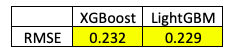

	
These results can be improved further if decide to use at least NLP for textual data as from Kaggle notebooks we see that some of the features give significant uplift in score. We hope to improve our solution in such way using NLP and might be phots as well (but not sure, it requires GPU)
